<a href="https://colab.research.google.com/github/hugocm93/grudes/blob/main/RecipeOriginClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Projeto de avaliação da sprint "Qualidade de Software, Segurança e Sistemas Inteligentes" do curso de Pós-graduação da PUC-Rio em Engenharia de Software.

Aluno: Hugo Costa Machado

## **Observação**: a execução do notebook demora em torno de 13 minutos.


# Contexto

 Este notebook produz um modelo de _machine learning_ (ML) supervisionado para fazer predições (classificação) sobre a origem gastronômica de uma receita baseadas em seus ingredientes.
 O _dataset_ utilizado foi o [Recipe Ingredients Dataset](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset/data?select=train.json) obtido do site [Kaggle](https://www.kaggle.com).

 O modelo produzido é utilizado no serviço do Grudes API.

#Importações

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib as jl
import math
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Definições

In [2]:
class DenseTransformer(TransformerMixin):
    """ Transformador de vetor esparso para array
    """

    def fit(self, X, y=None, **params):
        return self

    def transform(self, X, y=None, **params):
        return np.asarray(X.todense())

class IdentityTransformer(TransformerMixin):
    """ Transformador identidade
    """

    def fit(self, X, y=None, **params):
        return self

    def transform(self, X, y=None, **params):
        return X*1

#Carga dos _Dataset_ em conjunto de entrada e de saída
  O _dataset_ [Recipe Ingredients Dataset](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset) é composto de dois conjuntos: _train.json_ e _test.json_. O primeiro contém ingredientes e origem e a segundo contém somente os ingredientes. Como o modelo é supervisionado, somente o primeiro conjunto foi utilizado como dataset para o treino e teste.


In [3]:
recipes = pd.read_json('https://raw.githubusercontent.com/hugocm93/grudes_api/main/ML/dataset/train.json')

X = recipes.values[:,2]
Y = recipes.values[:,1]

# Pré-processamento
 Inicialmente os ingredientes são elementos de uma lista. Para o treinamento e teste é necessário concatenar todos os ingredientes numa só _string_.

In [4]:
X = [' '.join(ingredients) for ingredients in X]


# Separação do _Dataset_ em conjuntos de treino e test.

In [5]:
test_size = 0.20
seed = 7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=Y)


# Modelagem

## Escolha dos algoritmos e transformações a serem avaliados

In [6]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

scalers = [IdentityTransformer(), MinMaxScaler(), StandardScaler(with_mean=False)]

vectorizers = [CountVectorizer(), TfidfVectorizer()]

## Geração de pipelines a partir dos algoritmos e transformações

In [7]:
pipelines = []

for model in models:
    for scaler in scalers:
        for vectorizer in vectorizers:
            pipeline = Pipeline([
                (type(vectorizer).__name__, vectorizer),
            ])

            # Alguns pipelines precisam dos dados como não esparso
            if model[0] == 'NB' or isinstance(scaler, MinMaxScaler):
                pipeline.steps.append(('to_dense', DenseTransformer()))

            pipeline.steps.append((type(scaler).__name__, scaler))
            pipeline.steps.append(model)

            name = model[0] + '_' + type(vectorizer).__name__[0] + '_' + type(scaler).__name__[0]

            pipelines.append((name, pipeline))


## Avaliação dos pipelines
 Observação: o _dataset_ foi reduzido neste bloco por questões de tempo de processamento. Usar o _dataset_ todo pode demorar mais de 1h. O _dataset_ reduzido ainda ajuda a escolher o algoritmo com maior potencial para a estapa de _tunning_.

In [8]:
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

# Reduz dataset de treino
max = math.ceil(0.05 * len(X_train))
X_train_reduced = X_train[0:max]
Y_train_reduced = Y_train[0:max]

results = []
names = []

np.random.seed(seed)
for name, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train_reduced, Y_train_reduced, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN_C_I: 0.466352 (0.026085)
KNN_T_I: 0.635499 (0.040106)
KNN_C_M: 0.386545 (0.033485)
KNN_T_M: 0.588954 (0.036268)
KNN_C_S: 0.329949 (0.030303)
KNN_T_S: 0.514159 (0.028788)
CART_C_I: 0.489623 (0.017455)
CART_T_I: 0.465090 (0.025090)
CART_C_M: 0.482712 (0.025050)
CART_T_M: 0.466985 (0.023673)
CART_C_S: 0.485837 (0.024393)
CART_T_S: 0.463215 (0.019701)
NB_C_I: 0.517917 (0.032257)
NB_T_I: 0.505955 (0.031570)
NB_C_M: 0.510994 (0.031982)
NB_T_M: 0.495892 (0.032721)
NB_C_S: 0.460711 (0.027176)
NB_T_S: 0.460700 (0.026365)
SVM_C_I: 0.597107 (0.035640)
SVM_T_I: 0.642991 (0.035106)
SVM_C_M: 0.613432 (0.028671)
SVM_T_M: 0.626643 (0.035663)
SVM_C_S: 0.534249 (0.039881)
SVM_T_S: 0.536777 (0.036245)


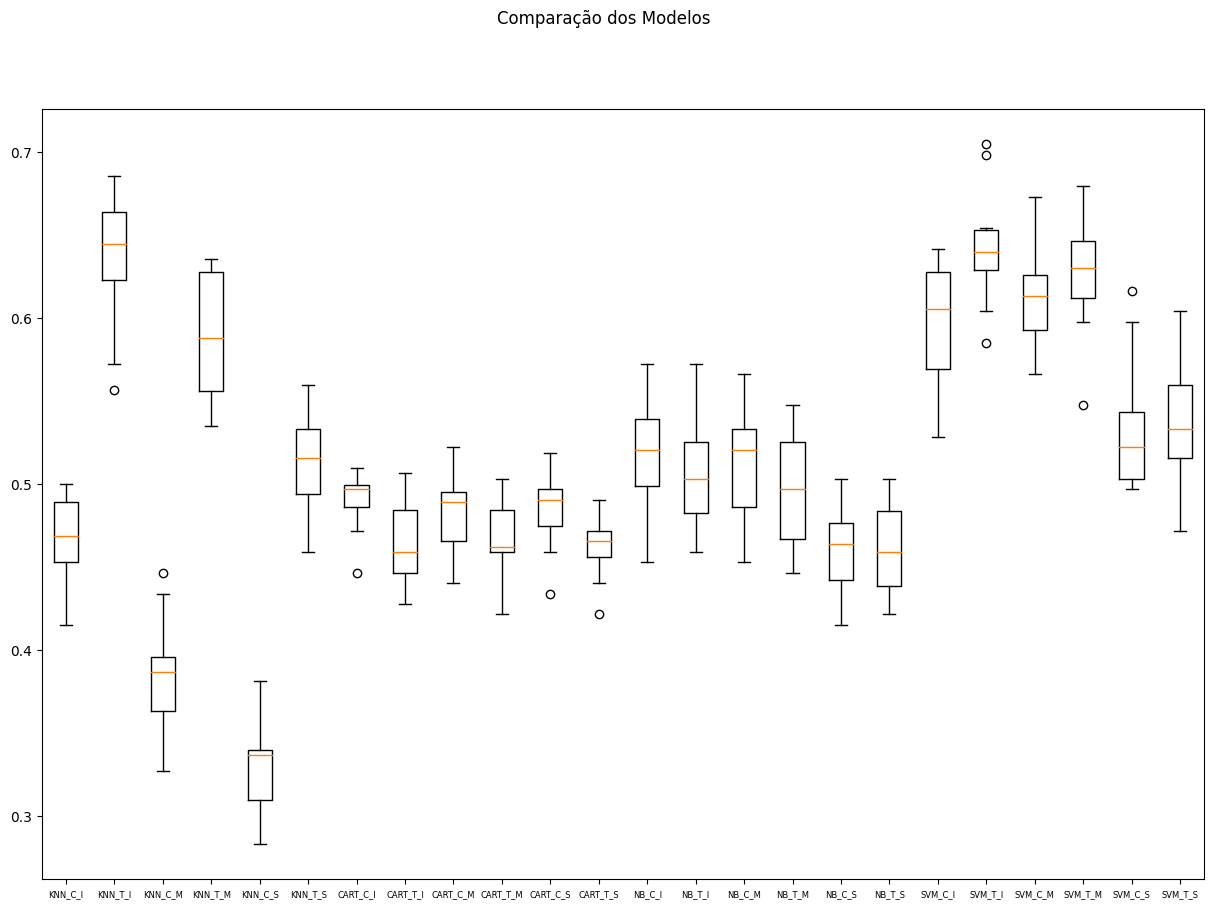

In [9]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(fontsize=6)
plt.show()

## Otimização de hiperparâmetros
 A configuração com melhor acurácia de acordo com a célula anterior é SMV com TfidfVectorizer. Então somente ele será considerado no ajuste de hiperparâmetros.  
 Observação: o _dataset_ foi reduzido neste bloco por questões de tempo de processamento. Além disto, a combinação de parâmetros também foi reduzida por causa do tempo de processamento. Porém, o bloco ainda serve para demonstrar a etapa de _tunning_ e uma pequena melhora dos resultados escolhendo um valor de C diferente.

 No final das contas, a própria parametrização default já se mostrou com bons resultados.

In [10]:
# Reduz dataset de treino
max = math.ceil(0.1 * len(X_train))
X_train_reduced = X_train[0:max]
Y_train_reduced = Y_train[0:max]

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('SVM', SVC())
])

parameters = {
    'SVM__kernel':('linear', 'rbf'),
    'SVM__C':[1, 10],
    }

search = GridSearchCV(pipeline, parameters)
search.fit(X_train_reduced, Y_train_reduced)

print(search.best_params_)
print(search.score(X_test, Y_test))

{'SVM__C': 10, 'SVM__kernel': 'rbf'}
0.7174104336895034


## Finalização do modelo

In [11]:
chosen = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('SVM', SVC(C=10, kernel='rbf'))
])

chosen.fit(X_train, Y_train)

# Guarda modelo para testes automatizados
jl.dump(chosen, 'model_dev.joblib')

print('Acurácia final: {}'.format(chosen.score(X_test, Y_test)))


Acurácia final: 0.8035197988686361


## Exportação do modelo final

In [12]:
# Utiliza todo o dataset para gerar o modelo final
chosen.fit(X, Y)
jl.dump(chosen, 'model.joblib')

['model.joblib']

# Análise de resultados

O modelo treinado apresentou uma acurácia de 0.8035.
Ao fazer algumas predições, podemos observar:
 * O modelo treinado utiliza um _dataset_ tendencioso, pois a quantidade de receitas de cada gastronomia não é a mesma. Ex.: sal somente indica gastronomia italiana porque é a que mais tem entradas no _dataset_.
 * As predições que resultam em gastronomia chinesa e vietnamita tem interseção de alguns ingredientes.
 * Sal, ovos, farinha e açúcar são ingredientes básicos, e não caracterizam gastronomia italiana ou francesa necessariamente.

In [13]:
print(chosen.predict(['olive oil pasta tomato'])[0]  == 'italian')
print(chosen.predict(['rice beans'])[0]              == 'mexican')
print(chosen.predict(['soy souce rice'])[0]          == 'japanese')
print(chosen.predict(['egg flour sugar'])[0]         == 'french')
print(chosen.predict(['cabbage pepper sausage'])[0]  == 'irish')
print(chosen.predict(['brocollis tofu rice'])[0]     == 'chinese')
print(chosen.predict(['brocollis tofu rice noodles'])[0]  == 'vietnamese')
print(chosen.predict(['salt'])[0]                    == 'italian')

True
True
True
True
True
True
True
True


# Conclusão

Fatos a serem considerados para a conclusão dos resultados:
 * Algumas gastronomias são parecidas umas com as outras por várias questões (culturais e geográficas por exemplo).
 * O _dataset_ não continha informação de quantidades de ingredientes e rendimento em porções, que poderiam contribuir para uma melhor classificação.
 * Muitos ingredientes são ingredientes base de qualquer gastronomia, e então não são servem como identificadores de origem.  
 * Receitas são adotadas e modificadas por gastronomias, introduzindo pequenas variações nas receita que dificultam a classificação.

Para receitas básicas ou com poucos ingredientes, o modelo não apresenta um bom resultado e demonstra _bias_ adquirido do seu _dataset_ de treino.
 Para receitas com vários ingredientes, o modelo apresentou um bom resultado, dando a gastronomia correta, ou por vezes uma gastronomia parecida nos quesitos culturais e geográficos.  

O modelo poderia ser utilizado, por exemplo, para dar um bom chute inicial para várias receitas de um banco de dados de forma automática.

Para este trabalho, o modelo foi interessante e apresentou bom resultado quando aplicado às receitas do banco de dados utilizado (The Meal DB) pela aplicação **Grudes**.

# Reflexão sobre boas práticas de desenvolvimento de software seguro aplicadas a este trabalho

O modelo de ML não utiliza dados sensíveis, pois receitas culinárias são públicas.  No entando, a aplicação Grudes poderia se beneficiar de boas práticas de desenvolvimento. Apesar de a aplicação atual não ter contas de usuário, isto seria uma funcionalidade desejável. Sendo assim, a conta de usuário bem como seus dados pessoas e senhas deveriam ser transmitidos e armazenados de forma segura.

Além disto, como qualquer aplicação Web, seria importante desenvolvê-la garantindo todos os aspectos de segurança: integridade dos dados dos usuários e suas receitas, autenticidade, confidencialidade, autorização de acesso e disponibilidade dos serviços envolvidos.
